In [1]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline



In [2]:
def SIR(z, t, beta, gamma):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta * I * S / N - gamma * I
    dR = gamma * I 

    dzdt = [dS, dI, dR]
    return dzdt

def SIR_diffparam(z, t, beta, beta2, gamma, gamma2, errato = 0):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta2 * I * S / N - gamma * I
    dR = gamma2 * I 

    dzdt = [dS, dI, dR]
    return dzdt

# adattare il modello tempo-variabile -> così da considerare lockdown ecc? -> o con alcuni threshold

def plot_traj(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %R0 )
    plt.savefig('SIR.pdf', dpi=300)
    
def plot_traj_gray(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, color = 'lightgray')
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')

In [3]:
# oop con ereditarietà?

def SEIR(z, t, beta, gamma, lamb, mu, a):

    S, E, I, R = z

    dS = - beta * I * S / N 
    dE = beta * I * S / N - a * E
    dI = a * E - gamma  * I
    dR = gamma * I 

    dzdt = [dS, dE, dI, dR]
    return dzdt

def plot_traj_SEIR(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    x4 = trajectories[:,3]
    
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    r = plt.plot(x2, linewidth = width, label = 'Exposed')
    i = plt.plot(x3, linewidth = width, label = 'Infected')
    r = plt.plot(x4, linewidth = width, label = 'Removed')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %(a*beta/gamma) )
    plt.show()

In [3]:
data_size = 100

batch_time = 20  # tempo delle batches
niters = 500
#batch_size = 84  # dimensione delle batches
batch_size = data_size - batch_time - 1

N = 60000
infected_0 = 100
beta = 0.3 # farli time evolving?
gamma = 0.1

R0 = beta/gamma

In [4]:
t_grid = np.linspace(0, data_size-1, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions
true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento

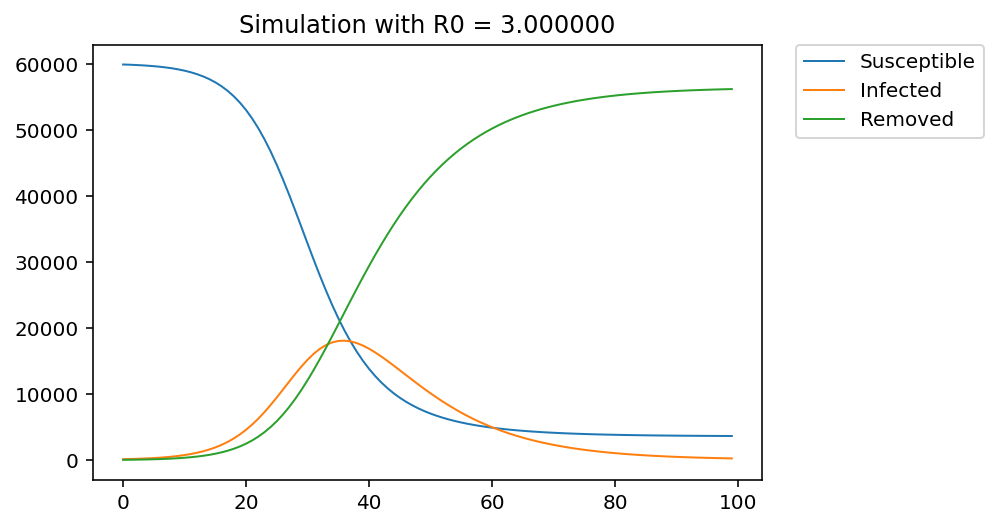

In [5]:
plot_traj(true_yy)

In [7]:

true_y = true_yy.copy()



from stochastic.processes.continuous import FractionalBrownianMotion

fbm = FractionalBrownianMotion(hurst=0.2, t= data_size)
# in questo modo è autocorrelato negativamente -> giorno da tanti tamponi seguito da giorno da pochi tamponi

noise = abs(N/200 * fbm.sample(data_size-1))
noise_2 = abs(N/200 * fbm.sample(data_size-1))


true_y[:,0] = abs(true_y[:,0] - noise)        
true_y[:,1] = abs(true_y[:,1] + noise - noise_2)
true_y[:,2] = N - true_y[:,0] - true_y[:,1]

# problema in realtà è che i suscettibili e i rimossi possono crescere/decrescere




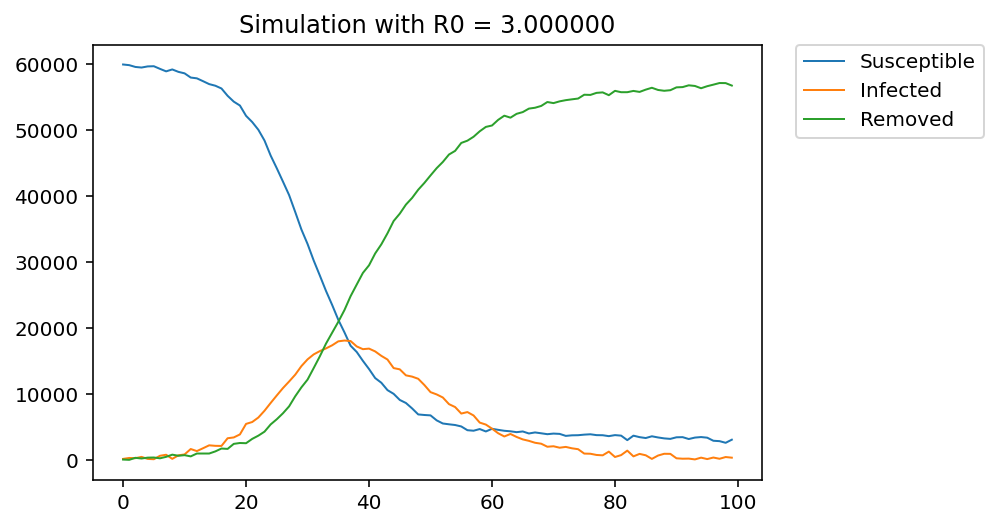

In [10]:
#true_y = true_yy
plot_traj(true_y)

In [8]:
sigma_s = np.std(true_y[:,0:1])  
sigma_i = np.std(true_y[:,1:2]) 
sigma_r = np.std(true_y[:,2:3]) 

true_y[:, 0:1] = true_y[:, 0:1]/sigma_s
true_y[:, 1:2] = true_y[:, 1:2]/sigma_i
true_y[:, 2:3] = true_y[:, 2:3]/sigma_r

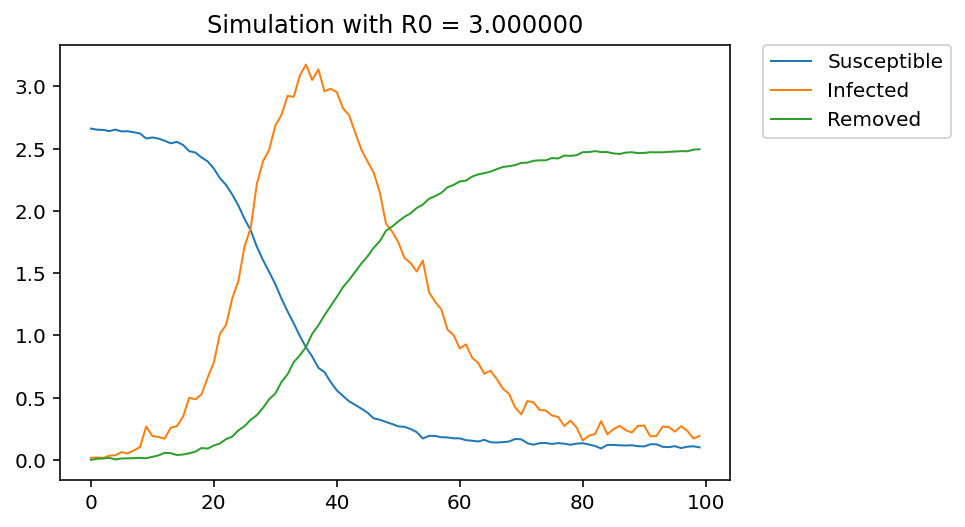

In [27]:
plot_traj(true_y)

In [9]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    # being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [10]:
num_param = 2 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 10)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch



In [11]:
from neural_ode import NeuralODE

In [12]:
niters_pre = 500  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]

        dS = - p1 * I * S / N 
        dI = p1 * I * S / N - p2 * I 
        dR = p2 * I 
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)  

In [13]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

#parameters_pre = np.zeros((para_num, niters_pre))
parameters_pre = np.zeros((para_num, 1))

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    #parameters_pre[:,step] = np.reshape(model_pre.trainable_weights[0].numpy(),(5,))
    parameters_pre = model_pre.trainable_weights[0].numpy()
print(parameters_pre)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:54<00:00,  9.13it/s]

[[0.32632366]
 [0.11178183]]


In [115]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        
        dS = - p1 * I * S / N 
        dI = p1 * I * S / N - p2 * I 
        dR = p2 * I 
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

temp_model = ODEModel()
neural_ode_temp = NeuralODE(temp_model, t=t_in)

# qua facciamo un temp neuralode con tempmodel

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

(2, 1) here


In [212]:
@tf.function
def compute_loss(batch_y0, batch_yN, neuralodes):
    pred_y = neuralodes.forward(batch_y0)  # This finds the predicted yNs
    loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2)
    return loss

In [228]:
w_temp = np.resize([0.32,0.11],(2,1))
temp_model.trainable_weights[0].assign(w_temp) 
compute_loss(batch_y0,batch_yN,neural_ode_temp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.06582027>

In [362]:
##########################################################################################################################

# DA QUI IN POI NUOVO

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0
# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
niters = 50000
naccepted = 0
accepted = False
eps = 0.1 # To be determined, it is a hyperparameter
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

#lambda_sim = np.exp(npr.normal())
lambda_sim = 100
w_sim = 0

for i in tqdm(range(niters)):

    # We will consider here the standard Lasso model for data approximation
    #lambda_temp = np.exp(npr.gamma(para_num+1, 1))
    
    #lambda_temp = npr.randint(low = 10, high = 100)
    lambda_temp = npr.uniform(low = 1, high = 10)
    
    #WW = model.trainable_weights[0].numpy() # illegale
    
    #npr.laplace(0, scale=1/lambda_sim, size=WW.size),(2,1)
    
    w_temp = np.resize([npr.normal(0.3, 1/lambda_sim),npr.normal(0.1, 1/lambda_sim)], (2,1))
    temp_model.trainable_weights[0].assign(w_temp) 

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < eps:
        parameters[i:i+1, :] = np.transpose(w_temp)
        lambdalist[i:i+1] = lambda_temp
        lambda_sim = lambda_temp
        w_sim = w_temp
        naccepted += 1
        accepted = True

    else:
        parameters[i:i + 1, :] = np.transpose(w_sim)
        lambdalist[i:i + 1] = lambda_sim
        accepted = False

    #print("Accepted = ", accepted)

print('Acceptance rate: ', naccepted / niters)

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')



  1%|▉                                                                             | 607/50000 [00:07<10:59, 74.85it/s]<ipython-input-362-22bdae26e0db>:61: RuntimeWarning: invalid value encountered in less
  if np.abs(initial_loss - sim_loss) < eps:
100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [11:47<00:00, 70.69it/s]


Acceptance rate:  0.0049


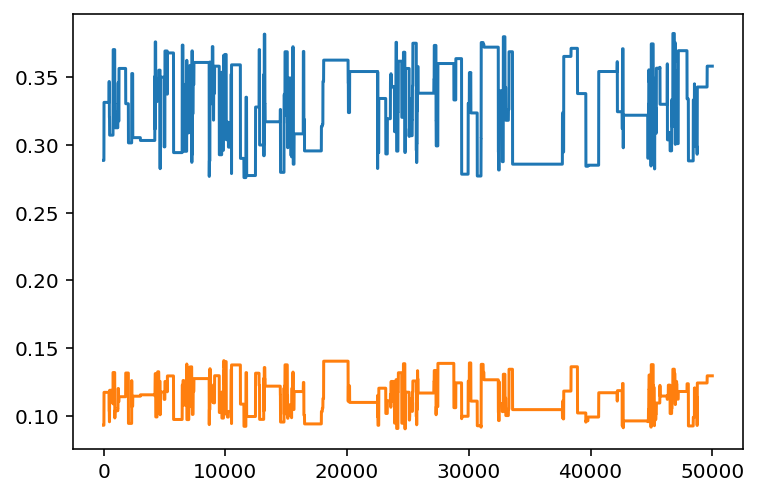

In [363]:
plt.plot(parameters)

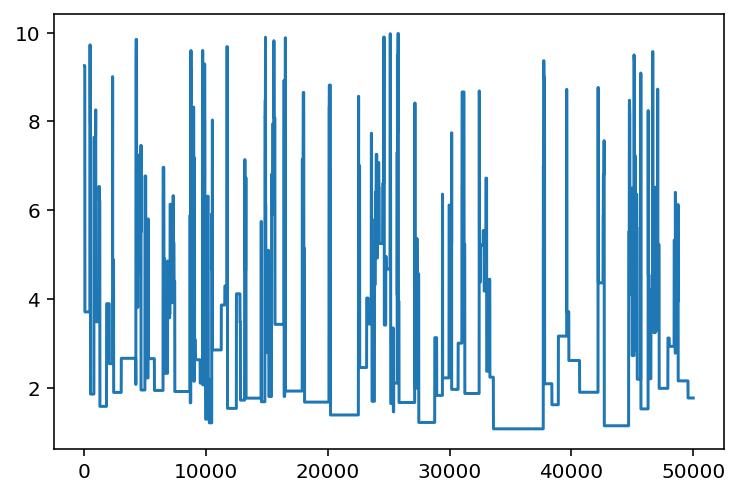

In [364]:
plt.plot(lambdalist)

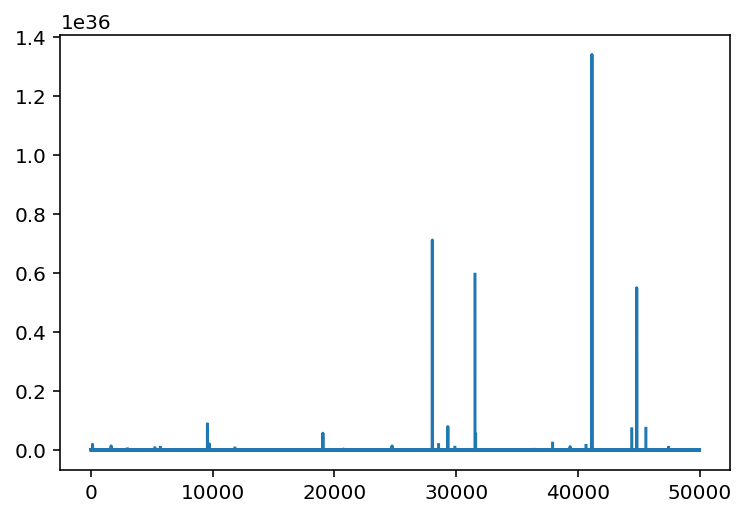

In [365]:
plt.plot(loss)

In [366]:
parameters

array([[0.28849535, 0.09282026],
       [0.28849535, 0.09282026],
       [0.28849535, 0.09282026],
       ...,
       [0.35814763, 0.12933423],
       [0.35814763, 0.12933423],
       [0.35814763, 0.12933423]])

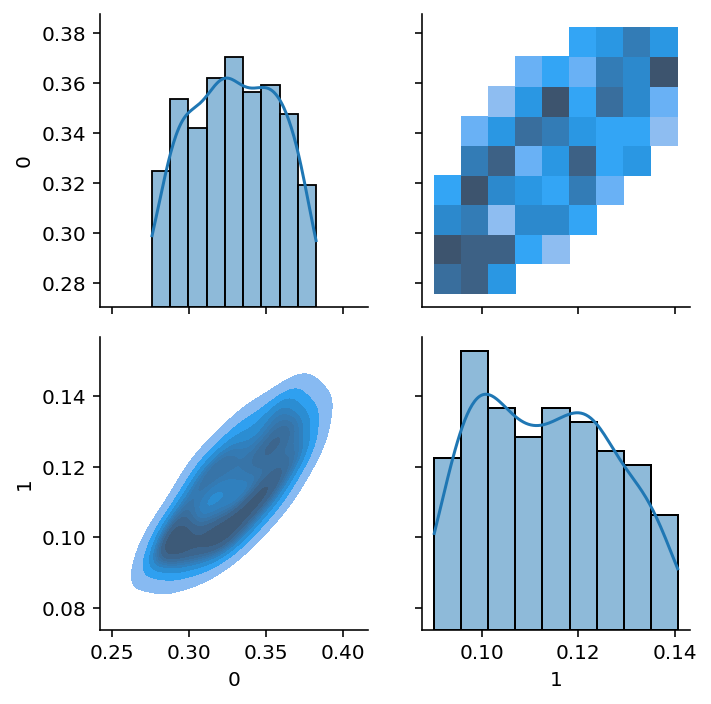

In [367]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(np.unique(parameters, axis = 0)))
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:54<00:00, 285.75it/s]


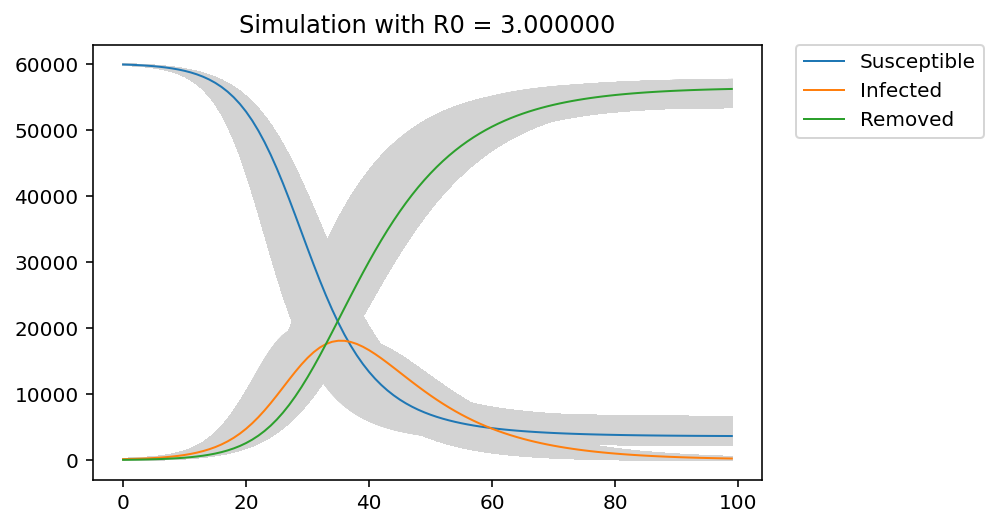

In [368]:
t_grid = np.linspace(0, data_size, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions

for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SIR, z0, t_grid, args=tuple(parameters[j]))
    plot_traj_gray(simul_yy)

true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento
plot_traj(true_yy)

    
plt.show()

In [369]:
import arviz as az

az.ess(parameters[:,1])

70.9720029194703

<AxesSubplot:title={'center':'x'}>

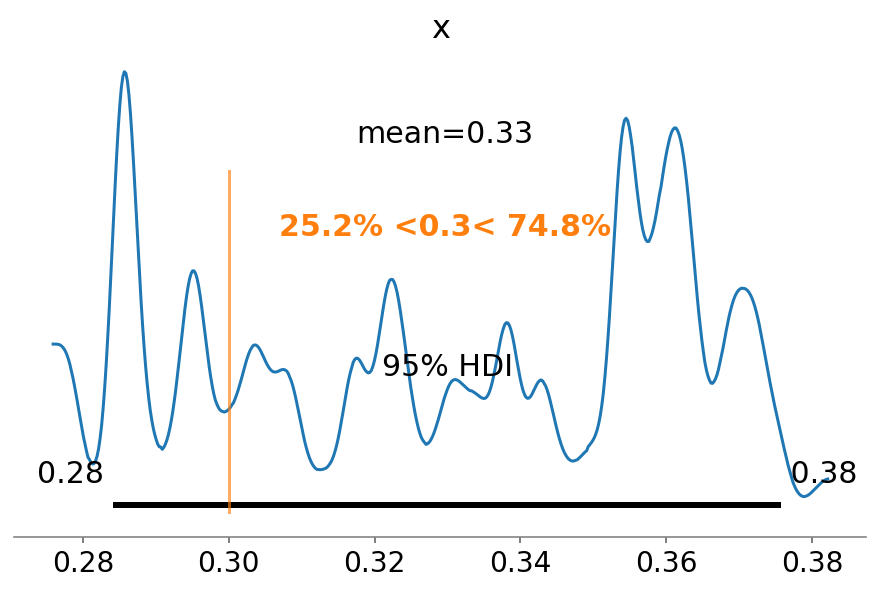

In [370]:
az.plot_posterior(parameters[:,0],hdi_prob = 0.95, ref_val = 0.3)

<AxesSubplot:title={'center':'x'}>

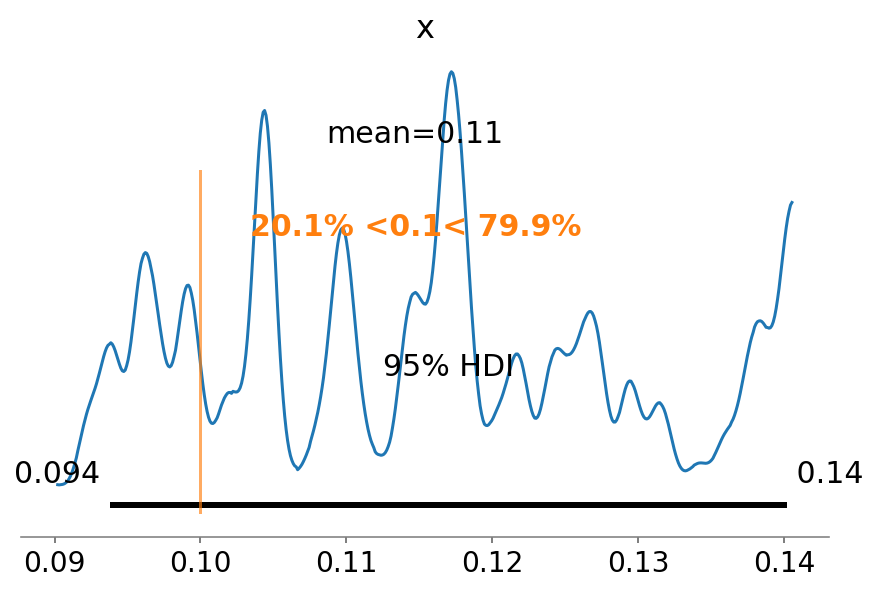

In [371]:
az.plot_posterior(parameters[:,1],hdi_prob = 0.95, ref_val = 0.1)

<AxesSubplot:title={'center':'x'}, xlabel='Quantile', ylabel='MCSE for quantiles'>

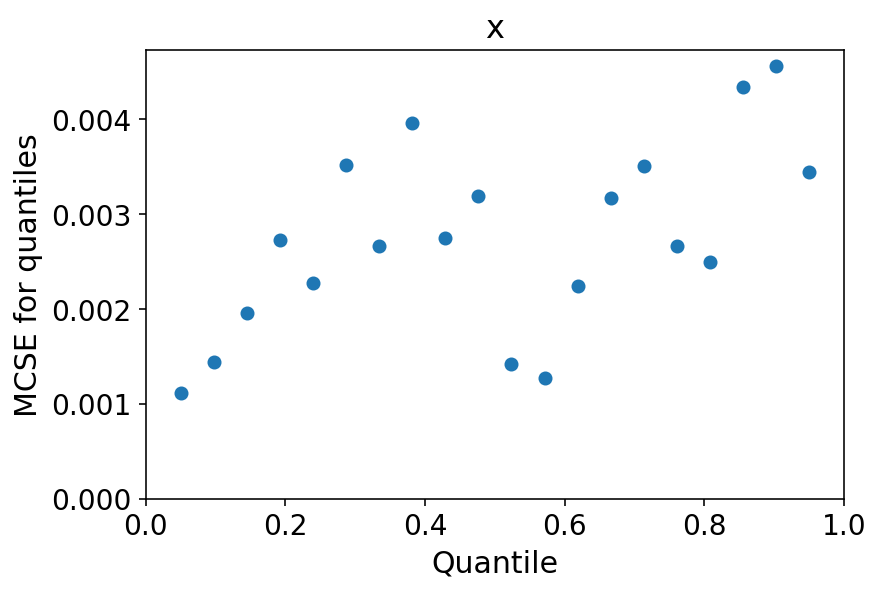

In [372]:
az.plot_mcse(parameters[:,1])

In [ ]:
# TO DO

# - simulation with only two parameters
# - go back to noisy simulation
# - thinning
# - weighted noise
# - CI for intensive therapy
# - sensitivity analysis!

# - understand why bayesian
# - sliding window for parameters estimation?
# - non observable states' estimation (through t-1?)
# - different dynamical systems interactions 

# - batch does not really make sense
# -> we always overestimate